### Метрические методы. Метод ближайших соседей.
Метрические методы представляют собой алгоритмы, которые фактически не имеют стадии обучения. Вместо этого они просто запоминают всю обучающую выборку, а на этапе предсказания ищут похожие на целевой объекты (lazy learning). Метрические модели являются непараметрическими, потому что они не делают явных допущений о глобальных законах, которым подчиняются данные. Например, когда мы использовали модель линейной регрессии, мы предполагали, что зависимость таргета $y$ от матрицы признаков $X$ яляется линейной; в случае линейной бинарной классификации (логистическая регрессия, SVM) полагали существования некоей гиперплоскости, которая хорошо разделяет классы. Метрические методы по сути своей **локальны**: они исходят из допущения, что свойства объекта можно узнать, имея представление о его соседях. Формально основой метода является *гипотеза компактности*: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных.

Рассмотрим очень наглядный и популярный метод, принадлежащий классу метрических - **метод ближайших соседей** (Метод $k$-ближайших соседей, $k$-nearest neighbors algorithm, kNN)

<center><img src="data//knn.png" alt="drawing" width="500"/></center>

Базовый алгоритм метода ближайших соседей для задачи классификации выглядит следующим образом:
1. Запоминаем датасет, т.е. координаты объектов в пространстве признаков
2. Берем новый объект и вычисляем расстояния до всех объектов в датасете
3. Выбираем $k$ соседей с минимальным расстоянием до нового объекта
4. Присваиваем новому наблюдению класс, наиболее часто встречающийся среди $k$ соседей

Если хотим обобщить метода на задачу регрессии, то вместо класса на 4 шаге возвращаем среднее (или медианное) значение целевого признака среди соседей.

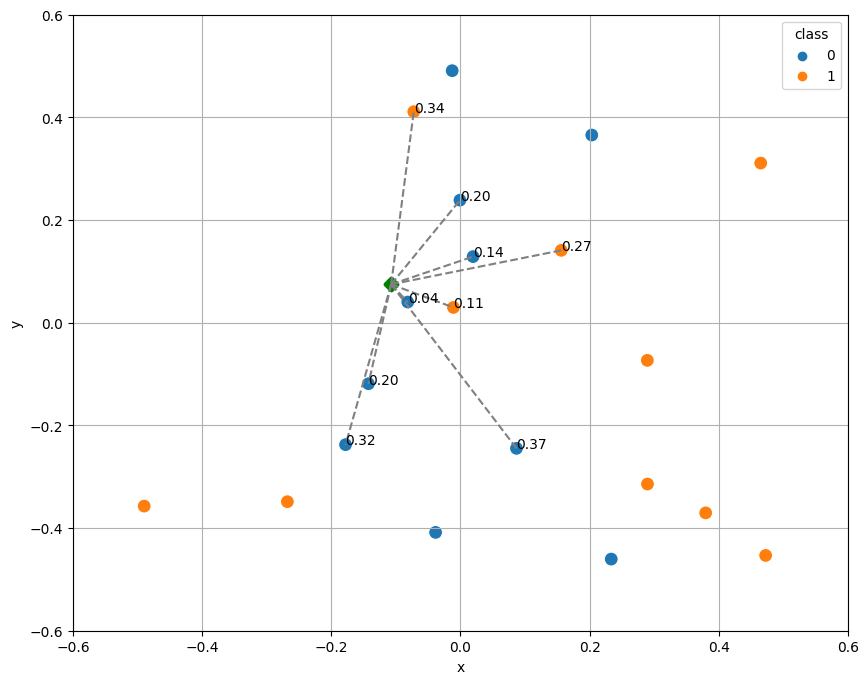

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

num_points = 20
x = np.random.rand(num_points)-0.5
y = np.random.rand(num_points)-0.5
point_cls = [1]*(num_points//2) + [0]*(num_points - num_points//2)

df = pd.DataFrame(data={
    'x': x, 
    'y': y,
    'class': point_cls
    })

# Координаты нового объекта
new_object = (np.random.rand(2)-0.5)/2

plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['x'], y=df['y'], hue=df['class'], s=100)
plt.scatter(new_object[0], new_object[1], c='g', marker='D', linewidths=3)
plt.xlim([-0.6, 0.6])
plt.ylim([-0.6, 0.6])
plt.grid()
# Найдем расстояния до всех объектов
dist = np.sqrt((x-new_object[0])**2+(y-new_object[1])**2)
# Найдем k ближайших
k = 9
nearest_ind = np.argsort(dist)[:k]

for ind in nearest_ind:
    plt.plot([new_object[0], x[ind]], [new_object[1], y[ind]], c='grey', linestyle='--')
    plt.text(x[ind], y[ind], f'{dist[ind]:.2f}')



Мы использовали евклидово расстояние в качестве метрики $\rho(x, y)=\sqrt{\sum\limits_{i}\left(x_i-y_i \right)^2}$. Однако, в некоторых случаях другие функции будут подходить лучше. Рассмотрим некоторые из них.
<center><img src="data//knn_metrics.png" alt="drawing" width="700"/></center>

- **Манхэттенская метрика** (Manhattan distance)
$$\rho(x, y) = \sum\limits_{i}|x_i-y_i|$$
Часто используется в высокоразмерных пространствах из-за лучшей устойчивости к выбросам. Если два объекта почти идентичны, но сильно отличаются по одному признаку, то скорее всего имеет выброс в этом признаке.
- **Метрика Минковского**
$$\rho(x, y) = \left( \sum\limits_i |x_i-y_i|^p\right)^{1/p}$$
Является обобщением евклидовой $\left( p=2 \right)$ и манхэттенской $\left( p=1 \right)$ метрик.
- **Косинусное расстояние**
$$\rho(x, y) = 1-cos\theta=1-\frac{x\cdot y}{||x||||y||} $$
Эта метрика хороша тем, что не зависит от норм векторов. Используется в задачах обработки естественного языка (NLP). Если превратить (определенным образом) слова в векторы, то с помощью данной метрики можно определять семантическую близость между словами/фразами.


Можно поставить задачу нахождения соседей более строго. Пусть у нас имеется выборка $X=(x_i, y_i)_{i=1}^n$, функция расстояния $\rho$ и вектор ответов, значения которого принадлежат множеству $Y=\{1, \dots K \}$. Пусть теперь требуется классифицировать новый объект $u$. Расположим объекты обучающей выборки $X$ в порядке неубывания расстояний до $u$:
$$\rho(u, x_u^{(1)})\leq\rho(u, x_u^{(2)})\leq\dots\leq\rho(u, x_u^{(n)}),$$
где $x_u^{(i)}$ - $i$-ый сосед объекта $u$. Тогда kNN алгоритм, относящий новый объект к тому классу, представителей которого окажется больше всего среди k его ближайших соседей имеет вид:
$$a(u)=arg max\sum\limits_{i=1}^k [y_u^{(i)}=y]$$


### Взвешенный kNN (weighted KNN)
У оригинального алгоритма есть один большой недостаток: он никак не учитывает расстояния до соседних объектов, хотя эта информация может быть полезной. Хотелось бы, чтобы вклад от близких объектов был больше, чем от далеких. Можно добавить в формулы выше веса, которые тем больше, чем ближе объект к целевому. Таким образом можно изменить вклад каждого отдельного слагаемого.
$$a(u)=arg max\sum\limits_{i=1}^k w_i[y_u^{(i)}=y]$$
Веса можно выбирать по-разному. 
- Можно использовать веса, зависящие только от номера объекта в отсортированном по близости массиве. Например *линейно затухающие* веса $w_i=\frac{k+1-i}{k}$ или *экспоненциально затухающие* $w_i=q^i,$ где $0<q<1$
- Чаще используют информацию о *расстояниях*, нежели о номере объекта (тем более расчитывать больше ничего не нужно: все расстояния мы уже рассчитали на более ранних этапах алгоритма). Для этого вводится **ядровая функция** (kernel function), которая является положительной, убывающей:
$$a(u)=arg max\sum\limits_{i=1}^k K\left(\frac{\rho(u, x_u^{(i)})}{h} \right) [y_u^{(i)}=y],$$
где $h$ - ширина окна.
Примеры ядер:
- $K(x) = \frac{1}{2} [|x|\leq1]$ - прямоугольное ядро
- $K(x) = (1-|x|) [|x|\leq1]$ - треугольное ядро
- $K(x) = \frac{1}{\sqrt{2\pi}} e^{-2x^2}$ - гауссовское ядро

Стоит отметить, что ширина окна сильнее влияет на качество модели, чем вид ядра. При слишком маленькой ширине модель сильно подстраивается под обучающую выборку и теряет свою обобщающую способность. При слишком большой ширине, напротив, модель становится слишком простой. Универсальной ширины окна не существует, поэтому для каждой задачи её приходится подбирать отдельно.

### Kernel regression
Чтобы обобщить алгоритм на задачу регрессии, необходимо немного преобразовать последнюю формулу. В задаче классификации активно используются скобки Айверсона, своего рода индикатор, равный 1, если классы объектов совпадают, и 0, если различаются. В задаче регрессии объекты являются вещественными числами, и для них функция, которая выдаёт отличное от нуля значение лишь в одной точке $y=y_i$, — плохая мера близости. Поэтому нам всего лишь надо заменить этот индикатор на какую-нибудь гладкую функцию для выражения близости. Например, можно взять квадрат евклидова расстояния:
$\left(y-y_u^{(i)} \right)^2$. А поскольку максимизация близости эквивалентна минимизации расстояния, можем записать выражение для нашего алгоритма в виде:
$$a(u)=arg min\sum\limits_{i=1}^k K\left(\frac{\rho(u, x_u^{(i)})}{h} \right) \left(y-y_u^{(i)}\right)^2$$
У данного оптимизационной задачи существует аналитическое решение, которое называется *формулой Надарая-Ватсона*:
$$a(u)= \frac{\sum\limits_{i=1}^k K\left(\frac{\rho(u, x_u^{(i)})}{h} \right)y_u^{(i)}}{\sum\limits_{i=1}^k K\left(\frac{\rho(u, x_u^{(i)})}{h} \right)}$$   

Плюсы алгоритма:
- Простота и высокая интерпретируемость
- Не делает явных предположений о распределении данных

Минусы:
- Необходимо хранить в памяти всю выборку
- Сложность вычислений $O(ND),$ где $N$ - количество объектов, $D$ - количество признаков
- Чувствителен к масштабу данных и к неинформативным признакам

Для ускорения поиска соседей существуют отдельные методы (точные и приближенные)

### kNN в Scikit-learn

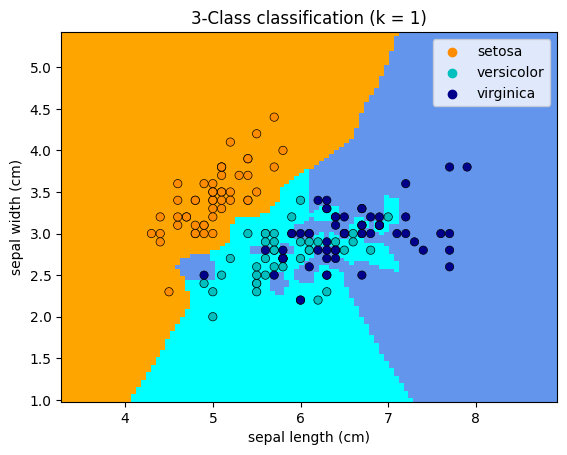

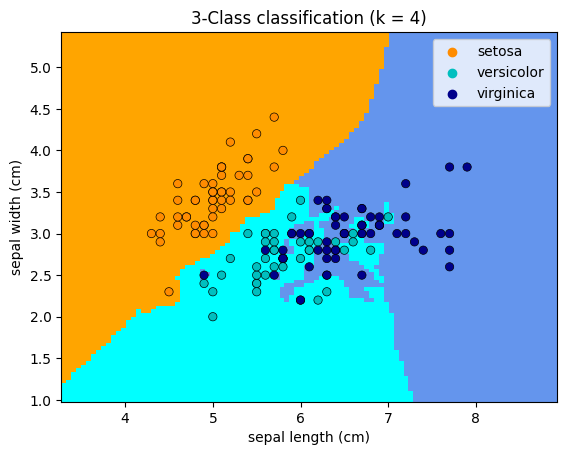

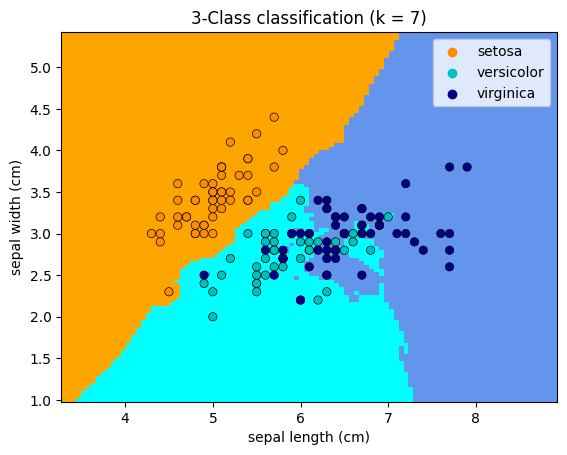

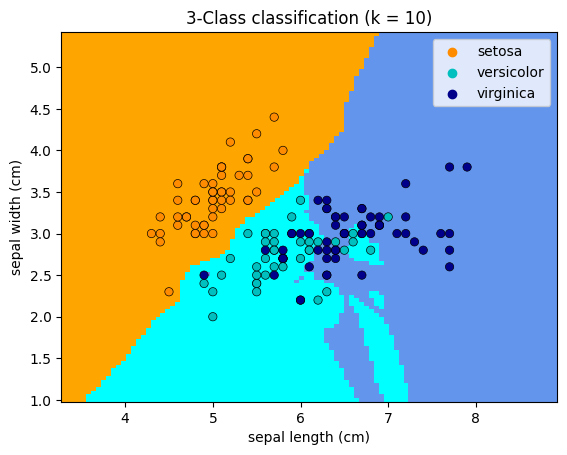

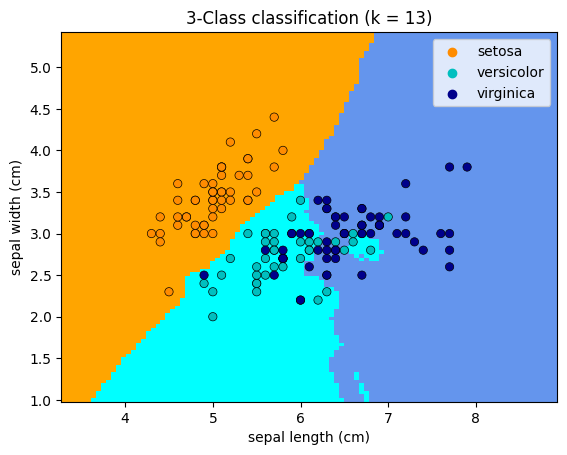

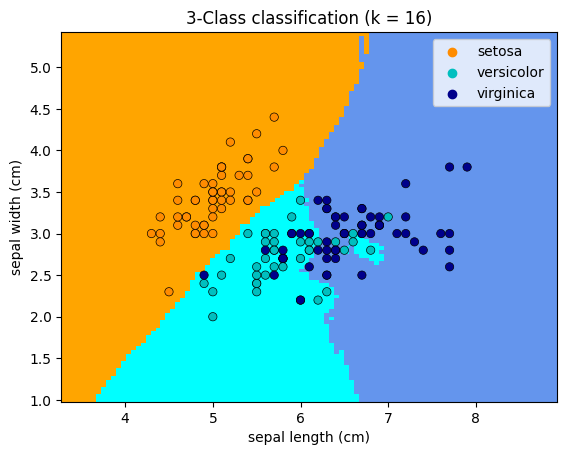

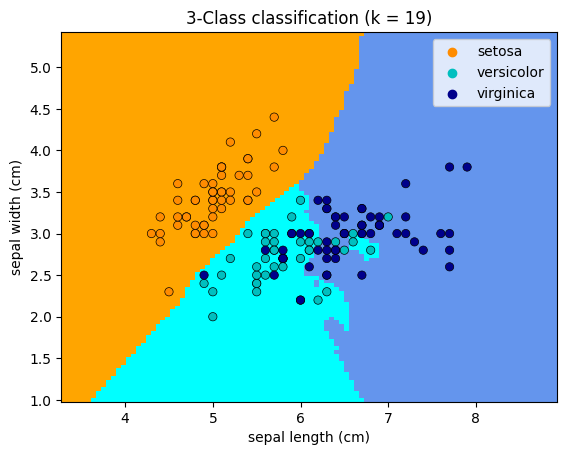

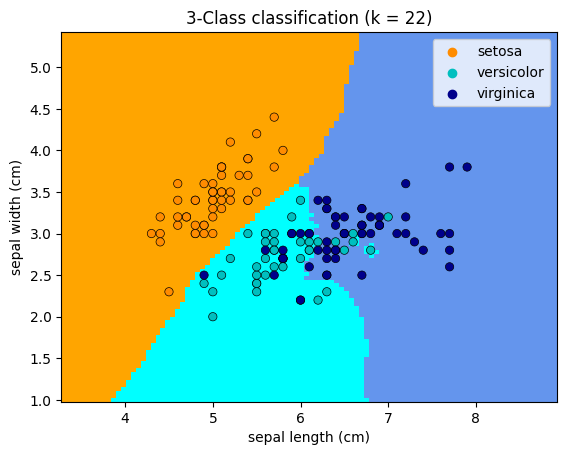

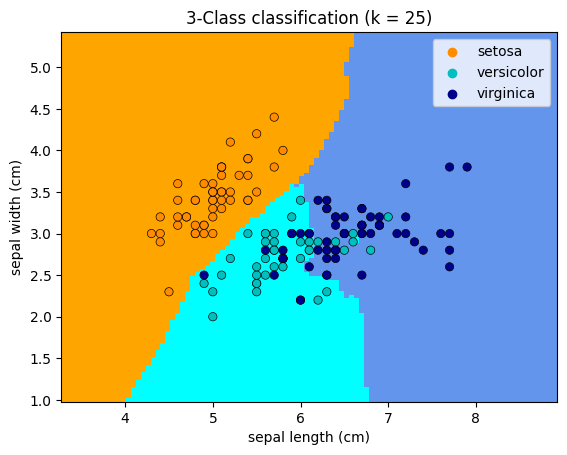

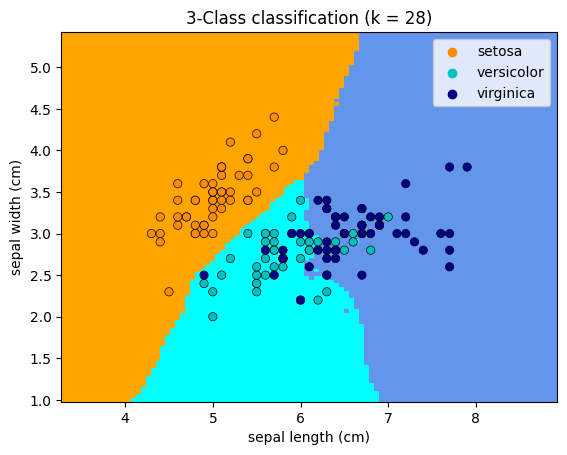

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.inspection import DecisionBoundaryDisplay

n_neighbors = list(range(1, 30, 4))
# n_neighbors = [1, 29]

# Импорт данных
iris = datasets.load_iris()

# Используем только два признака
X = iris.data[:, :2]
y = iris.target

# Сolor maps
cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
cmap_bold = ["darkorange", "c", "darkblue"]

for k_neigh in n_neighbors:
    # Создаем объект 
    clf = neighbors.KNeighborsClassifier(k_neigh, weights='distance')
    clf.fit(X, y)

    # Код ниже позволяет визуализировать границы классов
    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
        shading="auto",
    )

    # Отобразим данные
    sns.scatterplot(
        x=X[:, 0],
        y=X[:, 1],
        hue=iris.target_names[y],
        palette=cmap_bold,
        alpha=1.0,
        edgecolor="black",
    )
    plt.title(
        "3-Class classification (k = %i)" % (k_neigh,)
    )

plt.show()